# Fitting ML model

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [94]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier

In [70]:
df_train = pd.read_csv('../data/wrangled/train_wrangled.csv',)
df_test = pd.read_csv('../data/wrangled/test_wrangled.csv',)

In [71]:
df_train.head(0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [72]:
df_test.head(0)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,PassengerId


In [75]:
PassengerId = df_test["PassengerId"]
df_test.drop(columns = ['PassengerId'], inplace=True)

In [76]:
assert df_train.isnull().sum().max() == 0

In [77]:
assert df_test.isnull().sum().max() == 0

## Train - Test Split

In [78]:
#train = df_train[:df_train_len]
X_train = df_train.drop(labels = "Survived", axis = 1)
y_train = df_train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 589
X_test 291
y_train 589
y_test 291


In [79]:
acc_baseline = df_train["Survived"].value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.61


# Simple Logistic Regression

In [80]:
# Build model
logreg = make_pipeline(
        OneHotEncoder(use_cat_names = True),
        LogisticRegression(max_iter = 10000)
)
# Fit model to training data
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 80.31
Testing Accuracy: % 80.76


In [81]:
df_train["Sex"] = df_train["Sex"].astype("category")
df_train["Pclass"] = df_train["Pclass"].astype("category")
df_train["Embarked"] = df_train["Embarked"].astype("category")
#df_train["Survived"] = df_train["Survived"].astype("category")

In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  880 non-null    float64 
 1   Pclass    880 non-null    category
 2   Sex       880 non-null    category
 3   Age       880 non-null    float64 
 4   SibSp     880 non-null    int64   
 5   Parch     880 non-null    int64   
 6   Fare      880 non-null    float64 
 7   Embarked  880 non-null    category
dtypes: category(3), float64(3), int64(2)
memory usage: 37.5 KB


In [83]:
numerical_columns = df_train.select_dtypes(include=['int', 'float']).columns
numerical_columns=numerical_columns.drop('Survived')
numerical_columns

Index(['Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [84]:
categorical_columns = df_train.select_dtypes(include=['category']).columns
categorical_columns

Index(['Pclass', 'Sex', 'Embarked'], dtype='object')

In [85]:
assert len(numerical_columns) + len(categorical_columns) == len(df_train.columns) - 1

## Different ML models for Classification dataset 

We will compare 5 ml classifier and evaluate mean accuracy of each of them by stratified cross validation.
* Logistic Regression
* Decision Tree
* SVM
* Naive Bayes classifier
* Random Forest
* KNN
* AdaBoost.RT
* Gradient Boosting
* LightBGM
* Neural models

LightGBM (Light Gradient Boosting Machine) is a powerful and efficient gradient boosting algorithm widely used in machine learning for various tasks, particularly those involving tabular data. It's known for its speed, memory efficiency, and high accuracy, making it a popular choice for both research and production environments.

Here's a breakdown of LightGBM's key characteristics:

__Core Principle__: Like other boosting algorithms, LightGBM combines multiple weak models (e.g., decision trees) into a stronger ensemble model. Each model learns from the errors of the previous one, gradually improving overall performance.\
    It utilizes a gradient descent approach to minimize the loss function, aiming to reduce the difference between predictions and actual values.

__Strengths__:

1) __Speed__: LightGBM is significantly faster than many other gradient boosting algorithms, including XGBoost. This is achieved through several optimizations, like Gradient-based one-side sampling (GOSS): Only samples data points with larger gradients (errors) in each iteration, focusing on correcting significant mistakes.\
2) __Efficient feature splitting__: Uses efficient algorithms for finding optimal split points in decision trees.
3) __Parallelization across CPUs and GPUs__: Can leverage multi-core processors and GPUs for faster training.
4) __Memory Efficiency__: LightGBM consumes less memory compared to other algorithms, making it suitable for large datasets. This is achieved by:
5) __Feature importance-based splitting__: Focusing on relevant features instead of processing all features during splitting.
6) __Histograms for categorical features__: Represents categorical features efficiently using histograms.
7) __High Accuracy__: LightGBM often achieves state-of-the-art performance on various machine learning tasks, including classification and regression.

__Applications__:

1) __Classification__: Fraud detection, spam filtering, risk assessment, credit scoring.
2) __Regression__: Revenue prediction, customer lifetime value (CLTV) prediction, anomaly detection.
3) __Ranking__: Search result ranking, recommendation systems.

__Additional Notes__:

* LightGBM offers support for various data formats, including CSV, LibSVM, and dense/sparse matrices.
* It provides flexibility in hyperparameter tuning to optimize performance for different problems.
* While LightGBM is often praised for its speed, memory efficiency, and accuracy, it's crucial to evaluate different algorithms based on your specific dataset and task characteristics.


## Decision Tree & Hyperparameters

In [86]:
cv_result = []
best_estimators = []
decision_tree_hyperparameters = {
    "classifier__max_depth": range(1,20,2),  # List of possible values for maximum depth
    "classifier__min_samples_split": range(10,500,20),  # List of possible values for minimum samples to split
    "classifier__criterion": ["gini", "entropy"]  # List of possible splitting criteria (gini or entropy)
}

In [87]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

In [88]:
# Create pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Classifier without specifying criterion
])

In [89]:
# Create grid search object
grid_search = GridSearchCV(pipeline, param_grid=decision_tree_hyperparameters, cv=StratifiedKFold(n_splits = 10), scoring='accuracy', n_jobs=-1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

cv_result.append(grid_search.best_score_)
best_estimators.append(grid_search.best_estimator_)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 10}


In [90]:
cv_result

[0.8167153711279953]

In [92]:
predictions = grid_search.best_estimator_.predict(df_test)
output = pd.DataFrame({'PassengerId':PassengerId , 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
output = pd.Series(grid_search.best_estimator_.predict(test), name = "Survived").astype(int)
results = pd.concat([passenger_Id, output],axis = 1)
results.to_csv("titanic.csv", index = False)

# Voting classifier

In [95]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [97]:
train_df_vc = df_train.copy()
train_df_vc = pd.get_dummies(train_df_vc,columns=categorical_columns)
train_df_vc.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,22.0,1,0,7.2500,False,False,True,False,True,False,False,True
1,1.0,38.0,1,0,71.2833,True,False,False,True,False,True,False,False
2,1.0,26.0,0,0,7.9250,False,False,True,True,False,False,False,True
3,1.0,35.0,1,0,53.1000,True,False,False,True,False,False,False,True
4,0.0,35.0,0,0,8.0500,False,False,True,False,True,False,False,True


In [99]:
#train = df_train[:df_train_len]
X_train_vc = train_df_vc.drop(labels = "Survived", axis = 1)
y_train_vc = train_df_vc["Survived"]
X_train_vc, X_test_vc, y_train_vc, y_test_vc = train_test_split(X_train_vc, y_train_vc, test_size = 0.33, random_state = 42)
print("X_train",len(X_train_vc))
print("X_test",len(X_test_vc))
print("y_train",len(y_train_vc))
print("y_test",len(y_test_vc))

X_train 589
X_test 291
y_train 589
y_test 291


In [103]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train_vc,y_train_vc)
    print(f"{classifier} is performed")
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
[DecisionTreeClassifier(random_state=42), SVC(random_state=42), RandomForestClassifier(random_state=42), LogisticRegression(random_state=42), KNeighborsClassifier()] is performed
0.8150204558737582
Fitting 10 folds for each of 28 candidates, totalling 280 fits
[DecisionTreeClassifier(random_state=42), SVC(random_state=42), RandomForestClassifier(random_state=42), LogisticRegression(random_state=42), KNeighborsClassifier()] is performed
0.8048509643483343
Fitting 10 folds for each of 54 candidates, totalling 540 fits
[DecisionTreeClassifier(random_state=42), SVC(random_state=42), RandomForestClassifier(random_state=42), LogisticRegression(random_state=42), KNeighborsClassifier()] is performed
0.8353886616014027
Fitting 10 folds for each of 14 candidates, totalling 140 fits


C:\Users\Nithish P T\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nithish P T\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nithish P T\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\Lo

[DecisionTreeClassifier(random_state=42), SVC(random_state=42), RandomForestClassifier(random_state=42), LogisticRegression(random_state=42), KNeighborsClassifier()] is performed
0.803156049094097
Fitting 10 folds for each of 40 candidates, totalling 400 fits
[DecisionTreeClassifier(random_state=42), SVC(random_state=42), RandomForestClassifier(random_state=42), LogisticRegression(random_state=42), KNeighborsClassifier()] is performed
0.775978959672706


Text(0.5, 1.0, 'Cross Validation Scores')

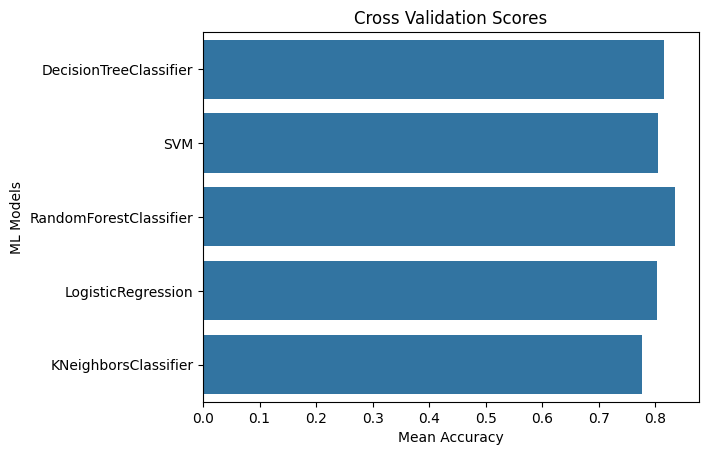

In [105]:
import seaborn as sns
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, "ML Models":["DecisionTreeClassifier", "SVM","RandomForestClassifier",
             "LogisticRegression",
             "KNeighborsClassifier"]})

g = sns.barplot(x="Cross Validation Means", y="ML Models", data = cv_results)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")

## Ensemble Modeling

In [110]:
votingC = VotingClassifier(estimators = [("dt",best_estimators[0]),
                                         #("svm",best_estimators[1]),
                                         ("rfc",best_estimators[2]),
                                         ("lr",best_estimators[3])],
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train_vc, y_train_vc)
print(accuracy_score(votingC.predict(X_test_vc),y_test_vc))

0.8075601374570447
